In [1]:
# Наш продукт - новостная лента. Планируется внедрить новые алгоритмы рекомендации постов, чтобы выбрать, какой из алгоритмов будет основным, проводится AB-тест. Перед тем, как начать проводить AB-тесты, нужно обязательно пройти стадию АА-тестирования, чтобы убедиться в надежности и корректности нашей системы складывания. У нас есть данные АА-теста с '2022-01-07' по '2022-01-13'.Cделаем симуляцию, как будто мы провели 10000 АА тестов. 
# На каждой итерации сформируем подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. 
# Проведем сравнение этих подвыборок t-testом. 

In [2]:
import seaborn as sns
import pandahouse 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
import hashlib
from scipy import stats
%matplotlib inline

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [4]:
q = """Select user_id,
exp_group,
countIf(action='like') likes,
countIf(action='view') views,
likes/ views ctr
From simulator_20220120.feed_actions
where toDate(time)>='2022-01-07' and toDate(time) <='2022-01-13' and
exp_group in (2, 3)
group by user_id, exp_group
"""

df = pandahouse.read_clickhouse (q, connection=connection)

In [5]:
df

,user_id,exp_group,likes,views,ctr
0,115383,3,11,36,0.305556
1,123580,3,15,92,0.163043
2,131473,2,26,148,0.175676
3,23985,2,12,66,0.181818
4,24523,2,17,120,0.141667
...,...,...,...,...,...
17044,122008,3,4,31,0.129032
17045,25383,2,16,57,0.280702
17046,122190,3,25,74,0.337838
17047,108927,2,8,33,0.242424


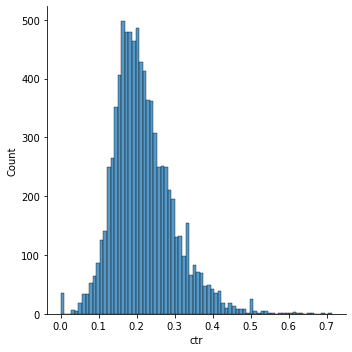

In [6]:
sns.displot(df[df.exp_group ==2].ctr, kde=False)

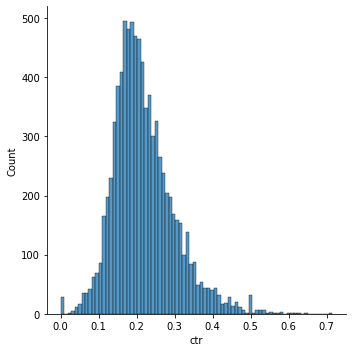

In [7]:
sns.displot(df[df.exp_group ==3].ctr, kde=False)

In [8]:
aa_test = []
for i in range(10000):
    aa_test.append(stats.ttest_ind(df[df.exp_group == 2].sample(n=500, replace=True).ctr, df[df.exp_group == 3].sample(n=500, replace=True).ctr,
                equal_var=False)[1])

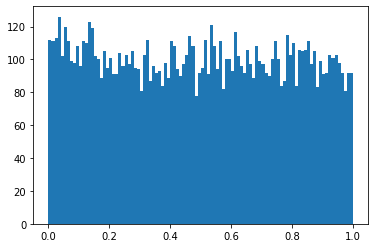

In [9]:
plt.hist(aa_test, bins=100)
plt.show()

In [10]:
count_less = 0

for item in aa_test:
    if item <= 0.05:
        count_less += 1
result_less = count_less/10000*100
result_less      

5.62

In [11]:
# В 5 % случаев мы получаем p-value меньше или равное 0.05, то есть только  примерно в 500 из 10000 итераций мы получим статистически значимые различия между группами. 
# Можно сказать, что система сплитирования работает нормально (превышение порога в 5% ложноположительных результатов следствие симуляции).